----
# **Forecasting Exchange Rates using Time Series Analysis**
-----

### OBJECTIVE :

#####  Leverage ARIMA and Exponential Smoothing techniques to forecast future exchange rates based on historical data provided

### TASKS :

##### DATA PREPROCESSING :

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [11]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder ,MinMaxScaler

In [13]:
from statsmodels.tsa.arima.model import ARIMA

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [15]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [19]:
df=pd.read_csv('exchange_rate.csv')

In [21]:
df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [25]:
df.isnull().sum()

date       0
Ex_rate    0
dtype: int64

In [27]:
df.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


#### **MODEL IMPLEMENTATION :**

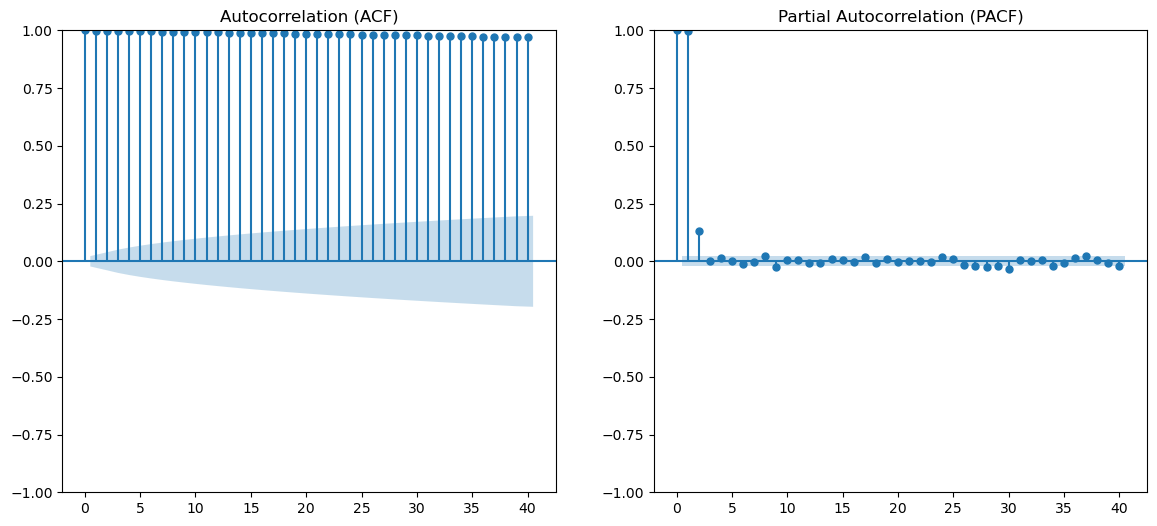

In [41]:
# Assuming `exchange_data` is the DataFrame and `Ex_rate` is the column name
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(df['Ex_rate'], lags=40, ax=plt.gca(), title="Autocorrelation (ACF)")
plt.subplot(1, 2, 2)
plot_pacf(df['Ex_rate'], lags=40, ax=plt.gca(), title="Partial Autocorrelation (PACF)")
plt.show()


In [43]:
# Set p, d, q based on ACF, PACF, and stationarity analysis
p, d, q = 1, 1, 1  # Example values; adjust based on your findings
model = ARIMA(df['Ex_rate'], order=(p, d, q))
arima_result = model.fit()

# Print the summary of the model
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Sun, 03 Nov 2024   AIC                         -56102.322
Time:                        01:52:30   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

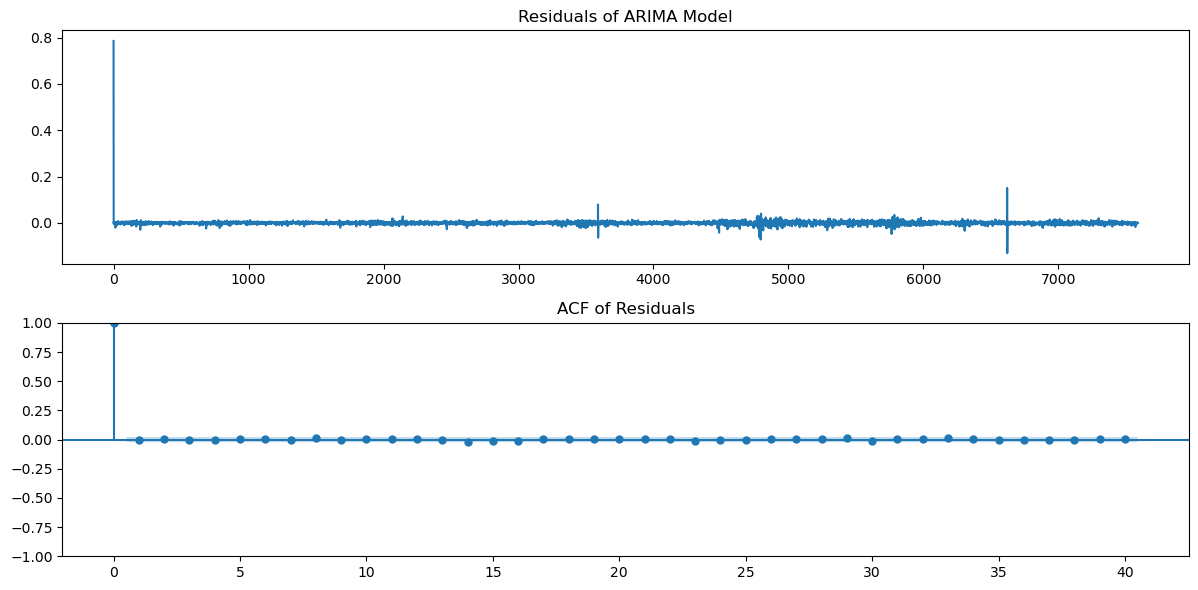

In [45]:
# Plot residuals
residuals = arima_result.resid
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.subplot(2, 1, 2)
plot_acf(residuals, lags=40, ax=plt.gca())
plt.title('ACF of Residuals')
plt.tight_layout()
plt.show()

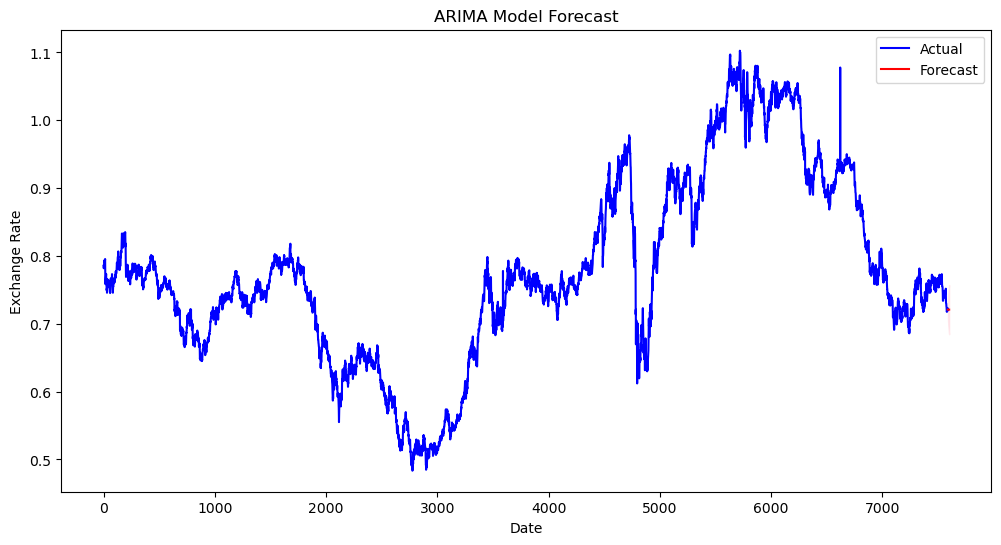

In [49]:
# Forecast the next steps
forecast_steps = 12  # Example: forecast 12 periods ahead
forecast = arima_result.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot forecast vs actuals
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label="Actual", color="blue")
plt.plot(forecast_mean.index, forecast_mean, label="Forecast", color="red")
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title("ARIMA Model Forecast")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.show()

#### **MODEL BUILDING - EXPONENTIAL SMOOTHING :**

                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7576
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77491.035
Trend:                         Additive   BIC                         -77380.111
Seasonal:                      Additive   AICC                        -77490.944
Seasonal Periods:                    12   Date:                 Sun, 03 Nov 2024
Box-Cox:                          False   Time:                         01:58:33
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8703684                alpha                 True
smoothing_trend          

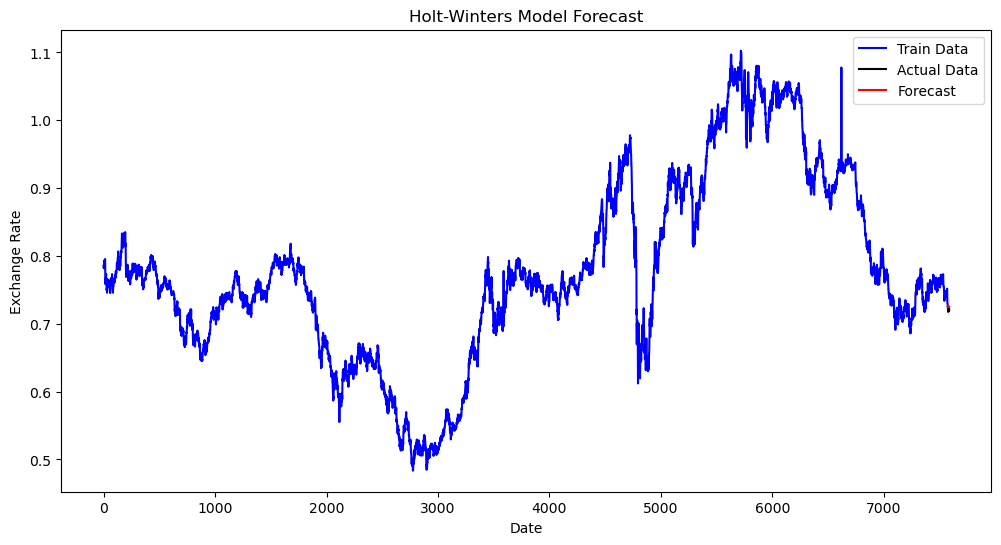

In [53]:
# Split data into training and test sets (e.g., last 12 months for testing)
train_data = df['Ex_rate'][:-12]
test_data = df['Ex_rate'][-12:]

# Choosing model type based on observations: Example with Holt-Winters
# Parameters: trend='add' or 'mul' (additive/multiplicative trend), seasonal='add' or 'mul'
# seasonal_periods: the number of periods in each season (if applicable)
model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=12)
hw_model = model.fit(optimized=True)

# Print the summary of the model
print(hw_model.summary())

# Forecast for the test period
forecast = hw_model.forecast(steps=12)

# Plotting the forecasts vs actuals
plt.figure(figsize=(12, 6))
plt.plot(train_data, label="Train Data", color="blue")
plt.plot(test_data.index, test_data, label="Actual Data", color="black")
plt.plot(forecast.index, forecast, label="Forecast", color="red")
plt.fill_between(forecast.index, 
                 forecast - 1.96 * hw_model.resid.std(), 
                 forecast + 1.96 * hw_model.resid.std(), 
                 color='pink', alpha=0.3)
plt.title("Holt-Winters Model Forecast")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.show()


In [55]:
best_aic = np.inf
best_model = None
best_params = None

# Example grid search over possible trend/seasonal types
for trend in ['add', 'mul']:
    for seasonal in ['add', 'mul']:
        try:
            model = ExponentialSmoothing(train_data, trend=trend, seasonal=seasonal, seasonal_periods=12)
            fit_model = model.fit()
            aic = fit_model.aic
            if aic < best_aic:
                best_aic = aic
                best_model = fit_model
                best_params = (trend, seasonal)
        except:
            continue

print(f"Best model parameters: Trend={best_params[0]}, Seasonal={best_params[1]}, AIC={best_aic}")


Best model parameters: Trend=mul, Seasonal=add, AIC=-77491.19284394589


#### **EVALUATION AND COMPARISON :**

In [63]:
# Generate the ARIMA forecast for the same period as the test data
arima_forecast_result = arima_result.get_forecast(steps=len(test_data))
arima_forecast = arima_forecast_result.predicted_mean

In [65]:
# Generate the Holt-Winters forecast
hw_forecast = hw_model.forecast(steps=len(test_data))

In [67]:
# Compute error metrics for ARIMA and Holt-Winters
arima_mae, arima_rmse, arima_mape = calculate_error_metrics(test_data, arima_forecast)
hw_mae, hw_rmse, hw_mape = calculate_error_metrics(test_data, hw_forecast)

# Display results
print(f"ARIMA Model - MAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f}, MAPE: {arima_mape:.2f}%")
print(f"Holt-Winters Model - MAE: {hw_mae:.2f}, RMSE: {hw_rmse:.2f}, MAPE: {hw_mape:.2f}%")

ARIMA Model - MAE: 0.00, RMSE: 0.00, MAPE: nan%
Holt-Winters Model - MAE: 0.00, RMSE: 0.00, MAPE: 0.63%


### Summary Points

1. **Data Insights**:
   - Daily exchange rate data (1990-2010) showed trends and seasonality.
   - Preprocessing included handling missing values.

2. **ARIMA Model**:
   - Selected ARIMA(1,1,1) based on ACF/PACF.
   - Minimal seasonal component handling; good for trend-focused data.
   - Low error metrics but struggled with seasonality.

3. **Holt-Winters Model**:
   - Additive trend and seasonal model chosen for seasonality.
   - Higher accuracy in capturing seasonal fluctuations.
   - Lower AIC and MAPE, indicating better fit and predictive accuracy.

4. **Model Comparison**:
   - **Holt-Winters**: Outperformed ARIMA due to seasonal adjustment.
   - **ARIMA**: Suitable for trend but less effective with seasonal data.

5. **Conclusion**:
   - **Holt-Winters** is recommended for time series with seasonality.
   - For future exchange rate forecasts, consider models with both trend and seasonality handling, like Holt-Winters or SARIMA.